In [1]:
from typing import Set
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from pylogics.parsers import parse_ltl

from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from stochastic_service_composition.declare_utils import *
from stochastic_service_composition.dfa_target import from_symbolic_automaton_to_declare_automaton
from stochastic_service_composition.dfa_target import mdp_from_dfa
from docs.notebooks.utils import render_service, render_target, render_composition_mdp, render_mdp_dfa, \
    print_policy_data, print_value_function, print_q_value_function, render_comp_mdp
from stochastic_service_composition.composition_mdp import composition_mdp, comp_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from stochastic_service_composition.target import build_target_from_transitions

## Use case for "Stochastic Service Composition with Industrial APIs" - Chip Production.

In this notebook, we present the implementation of the use case for "Stochastic Service Composition with Industrial APIs" about chip production.

# Available Services

In the following we provide definitions about available services:

In [2]:
LOW_PROB = 0.05

# probabilities of being broken after an action
DEFAULT_BROKEN_PROB = LOW_PROB
BROKEN_PROB = 0.5
HIGH_BROKEN_PROB = 0.7

# default probability of being unemployable after the configuration
DEFAULT_UNEMPLOYABLE_PROB = LOW_PROB
HIGH_UNEMPLOYABLE_PROB = 0.5

# costs of the machines that perform their job in different countries
DEFAULT_USA_REWARD = -1.0
WAR_REWARD = -3.0
USA_REWARD = -2.0
HIGH_USA_REWARD = -5.0
UK_REWARD = -6.8
CHINA_REWARD = -11.7
TAIWAN_REWARD = -12.2
RUSSIA_REWARD = -9.12 # we have to take into the account political problems
NORWAY_REWARD = -7.16
BRAZIL_REWARD = -6.7
FRANCE_REWARD = -7.6
MALAYSIA_REWARD = -14.73
TURKEY_REWARD = -10.16
KAZAKHSTAN_REWARD = -10.4
CHILE_REWARD = -7.8
BOLIVIA_REWARD = -6.8
ARGENTINA_REWARD = -8.55
MOROCCO_REWARD = -7.9
JAPAN_REWARD = -10.1
SOUTH_KOREA = -10.7
NETHERLANDS_REWARD = -7.5
#ISRAEL_REWARD = -10.81 # we have to take into the account political/religious problems

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -10.0

In [3]:
# all the atomic actions for the task
PICK_BUY_DESIGN = "pick_buy_design"
PICK_SILICON = "pick_silicon"
PICK_WAFER = "pick_wafer"
PICK_BORON = "pick_boron"
PICK_PHOSPHOR = "pick_phosphor"
CLEANING = "cleaning"
FILM_DEPOSITION = "film_deposition"
RESIST_COATING = "resist_coating"
EXPOSURE = "exposure"
DEVELOPMENT = "development"
ETCHING = "etching"
IMPURITIES_IMPLANTATION = "impurities_implantation"
ACTIVATION = "activation"
RESIST_STRIPPING = "resist_stripping"
ASSEMBLY = "assembly"
TESTING ="testing"
PACKAGING = "packaging"

ALL_SYMBOLS = {
    PICK_BUY_DESIGN,
    PICK_SILICON,
    #PICK_WAFER,
    #PICK_BORON,
    #PICK_PHOSPHOR
    #CLEANING,
    #FILM_DEPOSITION,
    #RESIST_COATING,
    #EXPOSURE,
    #DEVELOPMENT,
    #ETCHING,
    #IMPURITIES_IMPLANTATION,
    #ACTIVATION,
    #RESIST_STRIPPING,
    #ASSEMBLY,
    #TESTING,
    #PACKAGING
}

In [4]:
# service names
DESIGN_SERVICE_NAME_USA = "design_usa"                                      # human
DESIGN_SERVICE_NAME_UK = "design_uk"                                        # human
DESIGN_SERVICE_NAME_CHINA = "design_china"                                  # human
DESIGN_SERVICE_NAME_TAIWAN = "design_taiwan"                                # human
SILICON_WAREHOUSE_SERVICE_NAME = "silicon_warehouse"                        # warehouse
WAFER_WAREHOUSE_SERVICE_NAME = "wafer_warehouse"                            # warehouse
BORON_WAREHOUSE_SERVICE_NAME = "boron_warehouse"                            # warehouse
PHOSPHOR_WAREHOUSE_SERVICE_NAME = "phosphor_warehouse"                      # warehouse
SILICON_SERVICE_NAME_CHINA = "silicon_china"                                # human
SILICON_SERVICE_NAME_RUSSIA = "silicon_russia"                              # human
SILICON_SERVICE_NAME_NORWAY = "silicon_norway"                              # human
SILICON_SERVICE_NAME_USA = "silicon_usa"                                    # human
SILICON_SERVICE_NAME_FRANCE = "silicon_france"                              # human
SILICON_SERVICE_NAME_BRAZIL = "silicon_brazil"                              # human
SILICON_SERVICE_NAME_MALAYSIA = "silicon_malaysia"                          # human
WAFER_SERVICE_NAME_JAPAN = "wafer_japan"                                    # human
WAFER_SERVICE_NAME_SOUTH_KOREA = "wafer_south_korea"                        # human
BORON_SERVICE_NAME_TURKEY = "boron_turkey"                                  # human
BORON_SERVICE_NAME_USA = "boron_usa"                                        # human
BORON_SERVICE_NAME_KAZAKHSTAN = "boron_kazakhstan"                          # human
BORON_SERVICE_NAME_CHILE = "boron_chile"                                    # human
BORON_SERVICE_NAME_CHINA = "boron_china"                                    # human
BORON_SERVICE_NAME_ARGENTINA = "boron_argentina"                            # human
BORON_SERVICE_NAME_RUSSIA = "boron_russia"                                  # human
BORON_SERVICE_NAME_BOLIVIA = "boron_bolivia"                                # human
PHOSPHOR_SERVICE_NAME_MOROCCO = "phosphor_morocco"                          # human
PHOSPHOR_SERVICE_NAME_CHINA = "phosphor_china"                              # human
PHOSPHOR_SERVICE_NAME_USA = "phosphor_usa"                                  # human
CLEANING_HUMAN_SERVICE_NAME = "cleaning_human"                              # human
CLEANING_SERVICE_NAME = "cleaning_machine"                                  # machine
FILM_DEPOSITION1_SERVICE_NAME = "film_deposition_machine1"                  # machine
FILM_DEPOSITION2_SERVICE_NAME = "film_deposition_machine2"                  # machine
RESIST_COATING1_SERVICE_NAME = "resist_coating_machine1"                    # machine
RESIST_COATING2_SERVICE_NAME = "resist_coating_machine2"                    # machine
EXPOSURE_HUMAN_SERVICE_NAME = "exposure_human"                              # human
EXPOSURE_SERVICE_NAME = "exposure_machine"                                  # machine
DEVELOPMENT1_SERVICE_NAME = "development1_machine"                          # machine
DEVELOPMENT2_SERVICE_NAME = "development2_machine"                          # machine
ETCHING1_SERVICE_NAME = "etching1_machine"                                  # machine
ETCHING2_SERVICE_NAME = "etching2_machine"                                  # machine
IMPURITIES_IMPLANTATION1_SERVICE_NAME = "impurities_implantation1_machine"  # machine
IMPURITIES_IMPLANTATION2_SERVICE_NAME = "impurities_implantation2_machine"  # machine
ACTIVATION_HUMAN_SERVICE_NAME = "activation_human"                          # human
ACTIVATION_SERVICE_NAME = "activation_machine"                              # machine
RESIST_STRIPPING1_SERVICE_NAME = "resist_stripping1_machine"                # machine
RESIST_STRIPPING2_SERVICE_NAME = "resist_stripping2_machine"                # machine
ASSEMBLY_HUMAN_SERVICE_NAME = "assembly_human"                              # human
ASSEMBLY_SERVICE_NAME = "assembly_machine"                                  # machine
TESTING_HUMAN_SERVICE_NAME = "testing_human"                                # human
TESTING_SERVICE_NAME = "testing_machine"                                    # machine
PACKAGING_HUMAN_SERVICE_NAME = "packaging_human"                            # human
PACKAGING_SERVICE_NAME = "packaging_machine"                                # human

We have different type of services:

- generic breakable machines;
- complex breakable machines;
- warehouse machines;
- human workers

In [5]:
def build_generic_breakable_service(service_name: str, action_name: str, broken_prob: float, broken_reward: float, action_reward: float):
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    success_prob = deterministic_prob - broken_prob
    transitions = {
        "available": {
          action_name: ({"done": success_prob, "broken": broken_prob}, action_reward),
        },
        "broken": {
            f"check_{action_name}": ({"available": 1.0}, broken_reward),
        },
        "done": {
            f"check_{action_name}": ({"available": 1.0}, 0.0),
        }
    }
    final_states = {"available"}
    initial_state = "available"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

def build_complex_breakable_service(service_name: str, action_name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    configure_success_prob = deterministic_prob - unemployable_prob
    op_success_prob = deterministic_prob - broken_prob
    transitions = {
        "ready": { # current state
            f"CONFIG[{action_name}]": # action
                (
                    {
                        "configured": deterministic_prob # next state : prob
                    },
                    0.0
                ),
        },
        "configured": {
            f"CHECKED[{action_name}]":
                (
                    {
                    "executing": configure_success_prob,
                    "broken": unemployable_prob
                    } if unemployable_prob > 0.0 else {"executing": configure_success_prob},
                    0.0
                ),
        },
        "executing": {
            action_name: # operation
                (
                    {
                        "ready": op_success_prob,
                        "broken": broken_prob
                    } if broken_prob > 0.0 else {"ready": op_success_prob},
                    action_reward
                ),
        },
        "broken": {
            f"RESTORE[{action_name}]":
               (
                   {
                       "repairing": deterministic_prob
                   },
                   broken_reward
               ),
        },
        "repairing": {
            f"REPAIRED[{action_name}]":
                (
                    {
                        "ready": deterministic_prob
                    },
                    0.0
                ),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

def build_generic_service_one_state(
    service_name: str,
    operation_names: Set[str],
    action_reward: float,
) -> Service:
    """Build the one state device."""
    transitions = {
        "ready": {
            operation_name: ({"ready": 1.0}, action_reward) for operation_name in operation_names
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

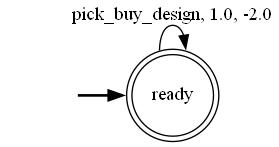

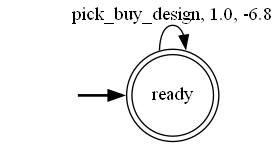

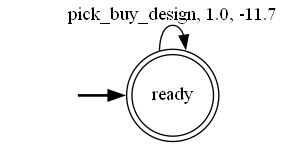

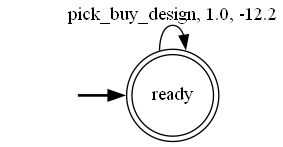

In [6]:
def design_service(name: str, action_reward: float) -> Service:
    """Build the design device."""
    return build_generic_service_one_state(
        name,
        {PICK_BUY_DESIGN},
        action_reward=action_reward
    )

service_design_usa = design_service(DESIGN_SERVICE_NAME_USA, USA_REWARD)
service_design_uk = design_service(DESIGN_SERVICE_NAME_UK, UK_REWARD)
service_design_china = design_service(DESIGN_SERVICE_NAME_CHINA, CHINA_REWARD)
service_design_taiwan = design_service(DESIGN_SERVICE_NAME_TAIWAN, TAIWAN_REWARD)
render_service(service_design_usa)
render_service(service_design_uk)
render_service(service_design_china)
render_service(service_design_taiwan)

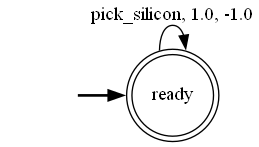

In [7]:
def silicon_warehouse_service(name: str = SILICON_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the silicon warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_SILICON},
        action_reward=action_reward
    )

service_silicon_warehouse = silicon_warehouse_service()
render_service(service_silicon_warehouse)

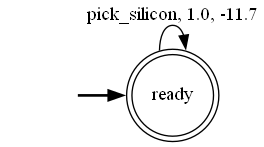

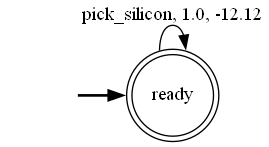

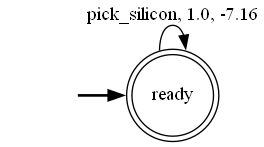

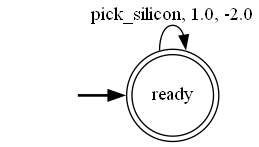

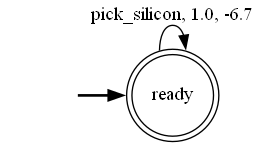

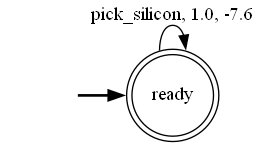

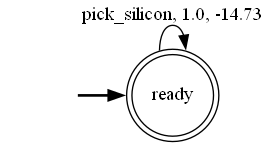

In [8]:
def silicon_service(name: str, action_reward) -> Service:
    """Build the silicon device."""
    return build_generic_service_one_state(
        name,
        {PICK_SILICON},
        action_reward=action_reward
    )

service_silicon_china = silicon_service(SILICON_SERVICE_NAME_CHINA, CHINA_REWARD)
service_silicon_russia = silicon_service(SILICON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD)
service_silicon_norway = silicon_service(SILICON_SERVICE_NAME_NORWAY, NORWAY_REWARD)
service_silicon_usa = silicon_service(SILICON_SERVICE_NAME_USA, USA_REWARD)
service_silicon_brazil = silicon_service(SILICON_SERVICE_NAME_BRAZIL, BRAZIL_REWARD)
service_silicon_france = silicon_service(SILICON_SERVICE_NAME_FRANCE, FRANCE_REWARD)
service_silicon_malaysia = silicon_service(SILICON_SERVICE_NAME_MALAYSIA, MALAYSIA_REWARD)
render_service(service_silicon_china)
render_service(service_silicon_russia)
render_service(service_silicon_norway)
render_service(service_silicon_usa)
render_service(service_silicon_brazil)
render_service(service_silicon_france)
render_service(service_silicon_malaysia)

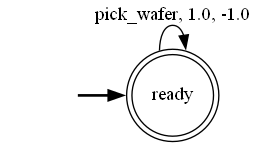

In [9]:
def wafer_warehouse_service(name: str = WAFER_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the wafer warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_WAFER},
        action_reward=action_reward
    )

service_wafer_warehouse = wafer_warehouse_service()
render_service(service_wafer_warehouse)

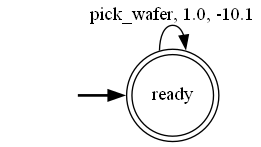

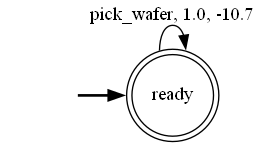

In [10]:
def wafer_service(name: str, action_reward: float) -> Service:
    """Build the wafer device."""
    return build_generic_service_one_state(
        name,
        {PICK_WAFER},
        action_reward=action_reward
    )

service_wafer_japan = wafer_service(WAFER_SERVICE_NAME_JAPAN, JAPAN_REWARD)
service_wafer_south_korea = wafer_service(WAFER_SERVICE_NAME_SOUTH_KOREA, SOUTH_KOREA)
render_service(service_wafer_japan)
render_service(service_wafer_south_korea)

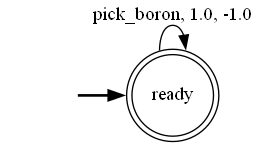

In [11]:
def boron_warehouse_service(name: str = BORON_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the boron warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_BORON},
        action_reward=action_reward
    )

service_boron_warehouse = boron_warehouse_service()
render_service(service_boron_warehouse)

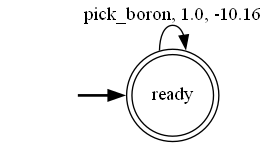

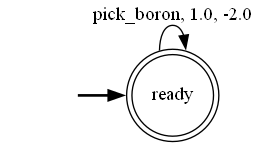

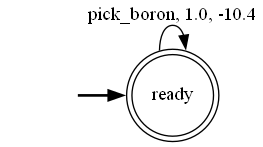

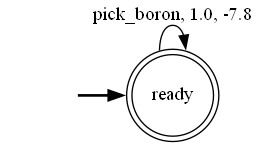

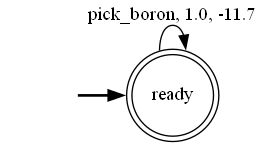

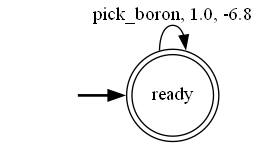

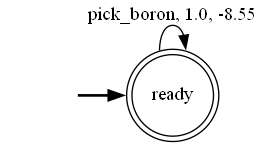

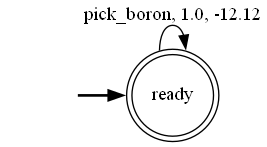

In [12]:
def boron_service(name: str, action_reward: float) -> Service:
    """Build the boron device."""
    return build_generic_service_one_state(
        name,
        {PICK_BORON},
        action_reward=action_reward
    )

service_boron_turkey = boron_service(BORON_SERVICE_NAME_TURKEY, TURKEY_REWARD)
service_boron_usa = boron_service(BORON_SERVICE_NAME_USA, USA_REWARD)
service_boron_kazakhstan = boron_service(BORON_SERVICE_NAME_KAZAKHSTAN, KAZAKHSTAN_REWARD)
service_boron_chile = boron_service(BORON_SERVICE_NAME_CHILE, CHILE_REWARD)
service_boron_china = boron_service(BORON_SERVICE_NAME_CHINA, CHINA_REWARD)
service_boron_bolivia = boron_service(BORON_SERVICE_NAME_BOLIVIA, BOLIVIA_REWARD)
service_boron_argentina = boron_service(BORON_SERVICE_NAME_ARGENTINA, ARGENTINA_REWARD)
service_boron_russia = boron_service(BORON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD)
render_service(service_boron_turkey)
render_service(service_boron_usa)
render_service(service_boron_kazakhstan)
render_service(service_boron_chile)
render_service(service_boron_china)
render_service(service_boron_bolivia)
render_service(service_boron_argentina)
render_service(service_boron_russia)

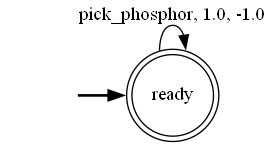

In [13]:
def phosphor_warehouse_service(name: str = PHOSPHOR_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the phosphor warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_PHOSPHOR},
        action_reward=action_reward
    )

service_phosphor_warehouse = phosphor_warehouse_service()
render_service(service_phosphor_warehouse)

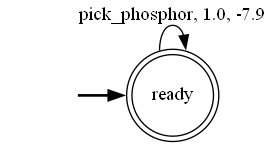

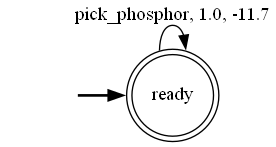

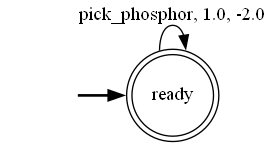

In [14]:
def phosphor_service(name: str, action_reward: float) -> Service:
    """Build the phosphor device."""
    return build_generic_service_one_state(
        name,
        {PICK_PHOSPHOR},
        action_reward=action_reward
    )

service_phosphor_morocco = phosphor_service(PHOSPHOR_SERVICE_NAME_MOROCCO, MOROCCO_REWARD)
service_phosphor_china = phosphor_service(PHOSPHOR_SERVICE_NAME_CHINA, CHINA_REWARD)
service_phosphor_usa = phosphor_service(PHOSPHOR_SERVICE_NAME_USA, USA_REWARD)
render_service(service_phosphor_morocco)
render_service(service_phosphor_china)
render_service(service_phosphor_usa)

# Target Specification
The target specification is defined as follows:

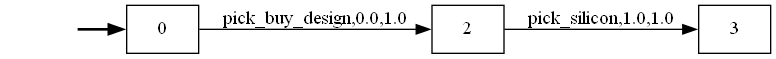

In [15]:
declare_constraints = [
    exactly_once(PICK_BUY_DESIGN),
    exactly_once(PICK_SILICON),
    #exactly_once(PICK_WAFER),
    #exactly_once(PICK_BORON),
    #exactly_once(PICK_PHOSPHOR),
    #exactly_once(CLEANING),
    #exactly_once(FILM_DEPOSITION),
    #exactly_once(RESIST_COATING),
    #exactly_once(EXPOSURE),
    #exactly_once(DEVELOPMENT),
    #exactly_once(ETCHING),
    #exactly_once(IMPURITIES_IMPLANTATION),
    #exactly_once(ACTIVATION),
    #exactly_once(RESIST_STRIPPING),
    #exactly_once(ASSEMBLY),
    #exactly_once(TESTING),
    #exactly_once(PACKAGING),
    alt_succession(PICK_BUY_DESIGN, PICK_SILICON),
    #alt_succession(PICK_BUY_DESIGN, PICK_WAFER),
    #alt_succession(PICK_BUY_DESIGN, PICK_BORON),
    #alt_succession(PICK_BUY_DESIGN, PICK_PHOSPHOR),
    #alt_succession(PICK_PHOSPHOR, CLEANING),
    #alt_succession(CLEANING, FILM_DEPOSITION),
    #alt_succession(FILM_DEPOSITION, RESIST_COATING),
    #alt_succession(RESIST_COATING, EXPOSURE),
    #alt_succession(EXPOSURE, DEVELOPMENT),
    #alt_succession(DEVELOPMENT, ETCHING),
    #alt_succession(ETCHING, IMPURITIES_IMPLANTATION),
    #alt_succession(IMPURITIES_IMPLANTATION, ACTIVATION),
    #alt_succession(ACTIVATION, RESIST_STRIPPING),
    #alt_succession(RESIST_STRIPPING, ASSEMBLY),
    #alt_succession(ASSEMBLY, TESTING),
    #alt_succession(TESTING, PACKAGING),
    build_declare_assumption(ALL_SYMBOLS),
]

formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
formula = parse_ltl(formula_str)
automaton = ltl2dfa(formula, backend="lydia")
declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, ALL_SYMBOLS)
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)


## Composition MDP
The Composition MDP is constructed in this way:

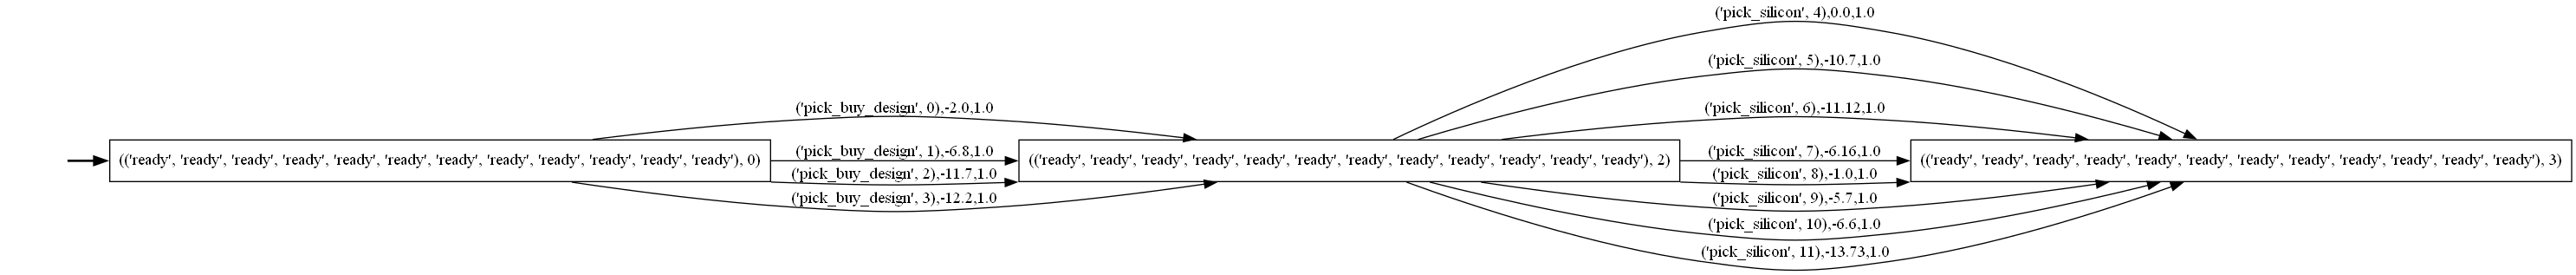

In [16]:
all_services = [
    design_service(DESIGN_SERVICE_NAME_USA, USA_REWARD),
    design_service(DESIGN_SERVICE_NAME_UK, UK_REWARD),
    design_service(DESIGN_SERVICE_NAME_CHINA, CHINA_REWARD),
    design_service(DESIGN_SERVICE_NAME_TAIWAN, TAIWAN_REWARD),
    silicon_warehouse_service(SILICON_WAREHOUSE_SERVICE_NAME, DEFAULT_USA_REWARD),
    silicon_service(SILICON_SERVICE_NAME_CHINA, CHINA_REWARD),
    silicon_service(SILICON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD),
    silicon_service(SILICON_SERVICE_NAME_NORWAY, NORWAY_REWARD),
    silicon_service(SILICON_SERVICE_NAME_USA, USA_REWARD),
    silicon_service(SILICON_SERVICE_NAME_BRAZIL, BRAZIL_REWARD),
    silicon_service(SILICON_SERVICE_NAME_FRANCE, FRANCE_REWARD),
    silicon_service(SILICON_SERVICE_NAME_MALAYSIA, MALAYSIA_REWARD)
    ]
mdp = comp_mdp(declare_automaton, all_services, gamma=0.9)
render_comp_mdp(mdp, no_sink = True)

# Optimal policy
Calculation of optimal policy:

In [17]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
_ = q_value_function.pop(0, None)

In [18]:
print_policy_data(opt_policy)

Policy:
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 0),	Action=('pick_silicon', 4)
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('pick_silicon', 4)
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 2),	Action=('pick_silicon', 4)
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 3),	Action=('pick_silicon', 4)


# Value Function
Calculation of Value Function:

In [20]:
print_value_function(value_function)

NameError: name 'value_function' is not defined

In [35]:
print_q_value_function(q_value_function)

Q-value function:
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'available', 'ready', 'available', 'ready', 'ready', 'available', 'ready', 'ready'), 's0', 'pick/buy_design'):
	Action=0,	Value=-4.68559
	Action=1,	Value=-10.48559
	Action=2,	Value=-15.38559
	Action=3,	Value=-15.88559

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'available', 'ready', 'available', 'ready', 'ready', 'available', 'ready', 'ready'), 's1', 'pick_silicon'):
	Action=4,	Value=-4.0951
	Action=5,	Value=-14.7951
	Action=6,	Value=-12.2151
	Act